In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import timeit
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

In [2]:
# Load in cleaned dataset of restaurant reviews
reviews = pickle.load( open( "restaurant_reviews_cleaned.pkl", "rb" ) )

In [3]:
reviews

,stars,text,good_bad,language,is_open,length
0,5,love deagans really atmosphere cozy festive sh...,Good,en,1.0,248
1,1,dismal lukewarm defrostedtasting texmex glop m...,Bad,en,0.0,285
2,4,oh happy day finally canes near casa yes other...,Good,en,1.0,501
3,5,definitely favorite fast food sub shop ingredi...,Good,en,1.0,355
4,5,really good place simple decor amazing food gr...,Good,en,1.0,246
...,...,...,...,...,...,...
5026161,5,confections cash casinos welcome las vegas fin...,Good,en,0.0,1014
5026162,3,solid american food southern comfort flare war...,Neutral,en,1.0,912
5026163,5,im honestly sure never place im definitely goi...,Good,en,1.0,685
5026164,3,food decent say service took way long order ev...,Neutral,en,1.0,214


In [4]:
# Creating a dataframe for performance metrics
d = {'Accuracy': [], 'Recall': [], 'F1-Score': []}
metrics = pd.DataFrame(data=d)
metrics.index.name = 'Model'
metrics

,Accuracy,Recall,F1-Score
Model,,,


# Naive Bayes Classifier

In [5]:
# Creating feature array and target array
def make_xy(reviews, vectorizer=None, min_df=0):    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df)
    X = vectorizer.fit_transform(reviews.text)
    X = X.tocsc()  # some versions of sklearn return COO format
    
    # Creating numeric target
    target_dict = {'Bad':0, 'Neutral':1, 'Good': 2}
    y = reviews.good_bad.map(target_dict)
    
    return X, y

# Timing start
start_time = timeit.default_timer()

# min_df tuned to 20 based on analysis below
min_df=20
vectorizer = CountVectorizer(min_df=20)
X, y = make_xy(reviews, vectorizer)

# Elapsed time calculation
elapsed = timeit.default_timer() - start_time

print('For min_df = ' + str(min_df))
print('Elapsed Time (minutes): ' + str(elapsed/60))


For min_df = 20
Elapsed Time (minutes): 4.732688534749999


In [8]:
pickle.dump( X, open( "X_vectorized_min_df_20.pickle", "wb" ) )

In [9]:
pickle.dump(y, open( "y_vectorized_min_df_20.pickle", "wb" ) )

In [6]:
# properties of reviews
print('Reviews is a ' + str(type(reviews.text)))
print('... with ' + str(len(reviews.text)) + ' elements <<< this is the expected number of reviews')
print('... and here are few elements of it: ')
reviews.text.head()

Reviews is a <class 'pandas.core.series.Series'>
... with 5026166 elements <<< this is the expected number of reviews
... and here are few elements of it: 


0    love deagans really atmosphere cozy festive sh...
1    dismal lukewarm defrostedtasting texmex glop m...
2    oh happy day finally canes near casa yes other...
3    definitely favorite fast food sub shop ingredi...
4    really good place simple decor amazing food gr...
Name: text, dtype: object

In [6]:
# Investigating shape
X_n_rows, X_n_cols = X.shape[0], X.shape[1]
print('X has ' + str(X_n_rows) + ' rows, and ' + str(X_n_cols) + ' columns')

X has 5026166 rows, and 74158 columns


In [7]:
1-74158/1251938

0.9407654372660627

# Min_df = 20 trims to 74k words. 

The Vectorized Matrix has the correct number of reviews and 74158 words for a 94% reduction in word list

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Training classifier
nBayes = MultinomialNB()
nBayes.fit(X_train,y_train)

# Accuracy Scores
acc_train = nBayes.score(X_train, y_train)
acc_test = nBayes.score(X_test, y_test)
features = nBayes.feature_count_.shape

print('The training accuracy is %f and the test accuracy is %f' %(acc_train, acc_test))
print('There are ' + str(X_n_rows) + ' reviews' + 
      ' and ' + str(X_n_cols) + ' features extracted by the vectorizer')

The training accuracy is 0.808370 and the test accuracy is 0.805562
There are 5026166 reviews and 74158 features extracted by the vectorizer


In [14]:
# Creating word frequencies
word_frequencies = np.array([X[:,i].count_nonzero() for i in range(X_n_cols)])

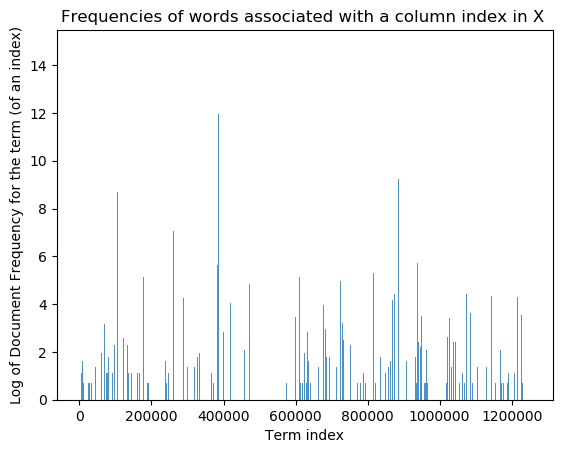

In [15]:
### Very Time intensive for full dataset. On the order of 8-20 hours

import math
plt.rcdefaults()
word_frequencies_log = [math.log(x) for x in word_frequencies]
x_values = [i for i in range(X_n_cols)]
plt.bar(x_values, word_frequencies_log, align='center', alpha=0.8)
plt.ylabel('Log of Document Frequency for the term (of an index)')
plt.xlabel('Term index')
plt.title('Frequencies of words associated with a column index in X ')
plt.show()

In [16]:
max_doc_freq = np.max(word_frequencies)
x_values = range(max_doc_freq)

In [17]:
y_values  = np.array([np.sum(word_frequencies <= i) for i in range(max_doc_freq)])/X_n_cols

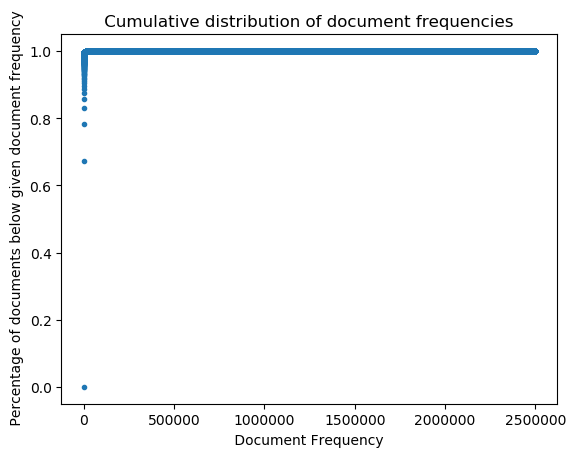

In [18]:
plt.plot(x_values, y_values, marker = '.',linestyle = 'none')
plt.ylabel(' Percentage of documents below given document frequency')
plt.xlabel(' Document Frequency ')
plt.title(' Cumulative distribution of document frequencies ')
plt.show()

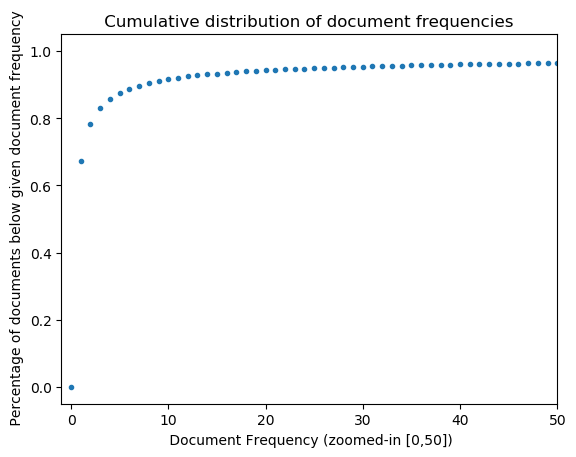

In [20]:
plt.plot(x_values, y_values, marker = '.',linestyle = 'none')
plt.xlim([-1,50])
plt.ylabel(' Percentage of documents below given document frequency')
plt.xlabel(' Document Frequency (zoomed-in [0,50])')
plt.title(' Cumulative distribution of document frequencies ')
plt.show()

In [8]:
# This can be used to see words in vectorizer
words = np.array(vectorizer.get_feature_names())
words[-1]

'茶餐廳'

# Document Frequency Tuning

min_df has been selected at 20. This removes 94% of the words present, but at a document count of larger than 5 million, words that do not appear in 20 documents (0.0004%) of documents are likely not words we care about. The word list still has words that are nonsensical so I would be open to a larger Min_df for consideration. 

In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Training classifier
nBayes = MultinomialNB()
nBayes.fit(X_train,y_train)

# Accuracy Scores
acc_train = nBayes.score(X_train, y_train)
acc_test = nBayes.score(X_test, y_test)
features = nBayes.feature_count_.shape

# Predictions for the test/training set
y_pred_test = nBayes.predict(X_test)
y_pred_train = nBayes.predict(X_train)

print('The training accuracy is %f and the test accuracy is %f' %(acc_train, acc_test))
print('There are ' + str(X_n_rows) + ' reviews' + 
      ' and ' + str(X_n_cols) + ' features extracted by the vectorizer')

The training accuracy is 0.808242 and the test accuracy is 0.806380
There are 5026166 reviews and 74158 features extracted by the vectorizer


In [10]:
print(confusion_matrix(y_test, nBayes.predict(X_test)))

[[160388  43604  12074]
 [ 25657  65076  36291]
 [ 23467  53540 585137]]


In [11]:
print (classification_report(y_test, y_pred_test) )

              precision    recall  f1-score   support

           0       0.77      0.74      0.75    216066
           1       0.40      0.51      0.45    127024
           2       0.92      0.88      0.90    662144

    accuracy                           0.81   1005234
   macro avg       0.70      0.71      0.70   1005234
weighted avg       0.82      0.81      0.81   1005234



In [12]:
# Classification reports
nbayes_report_test = classification_report(y_test, y_pred_test, output_dict = True)
nbayes_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_train['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_train['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Naive Bayes train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_test['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_test['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Naive Bayes test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8236,0.8064,0.8138


# Alpha Tuning

In [17]:
parameters = {'alpha':[1, 5, 10, 15, 20, 25, 30, 35, 40, 45]}
grid_search = GridSearchCV(nBayes, parameters, cv=5)
grid_search.fit(X, y)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_alpha',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [23]:
alphas=[1, 5, 10, 15, 20, 25, 30, 35, 40, 45]
for i in range(len(alphas)):
    print('alpha = ' + str(alphas[i]))
    print('score = ' + str(grid_search.cv_results_['mean_test_score'][i]))

alpha = 1
score = 0.8047792293370334
alpha = 5
score = 0.8066961974594552
alpha = 10
score = 0.8102380621730361
alpha = 15
score = 0.8136581640956546
alpha = 20
score = 0.8164585093289796
alpha = 25
score = 0.8184570505629938
alpha = 30
score = 0.8196812441133062
alpha = 35
score = 0.820258224658716
alpha = 40
score = 0.8203754113970768
alpha = 45
score = 0.8200365845457551


GridSearch_CV returns the best results as alpha=40 for min_df=10

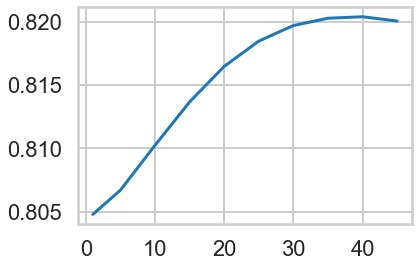

In [24]:
plt.plot(alphas,grid_search.cv_results_['mean_test_score'])

# Alpha = 40

In [13]:
# Train/test split only needed if skipping above code
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Training classifier
nBayes = MultinomialNB(alpha=40)
nBayes.fit(X_train,y_train)

# Accuracy Scores
acc_train = nBayes.score(X_train, y_train)
acc_test = nBayes.score(X_test, y_test)
features = nBayes.feature_count_.shape

# Predictions for the test/training set
y_pred_test = nBayes.predict(X_test)
y_pred_train = nBayes.predict(X_train)

print('The training accuracy is %f and the test accuracy is %f' %(acc_train, acc_test))
print('There are ' + str(X_n_rows) + ' reviews' + 
      ' and ' + str(X_n_cols) + ' features extracted by the vectorizer')

The training accuracy is 0.819405 and the test accuracy is 0.818915
There are 5026166 reviews and 74158 features extracted by the vectorizer


In [14]:
print ('Naive Bayes Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Naive Bayes Train Report:')
print (classification_report(y_train, y_pred_train ))

Naive Bayes Test Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76    216066
           1       0.44      0.36      0.40    127024
           2       0.90      0.92      0.91    662144

    accuracy                           0.82   1005234
   macro avg       0.70      0.68      0.69   1005234
weighted avg       0.81      0.82      0.81   1005234


Naive Bayes Train Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76    864264
           1       0.44      0.36      0.40    508093
           2       0.90      0.92      0.91   2648575

    accuracy                           0.82   4020932
   macro avg       0.70      0.69      0.69   4020932
weighted avg       0.81      0.82      0.81   4020932



In [15]:
# Classification reports
nbayes_report_test = classification_report(y_test, y_pred_test, output_dict = True)
nbayes_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_train['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_train['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['NB alpha 40 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_test['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_test['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['NB alpha 40 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8236,0.8064,0.8138
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8088,0.8189,0.8132


# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [17]:
# Split the data into a training and test set. Only needed if not split above.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2)

logRegression = LogisticRegression(solver = 'lbfgs', multi_class='auto')
# Fit the model on the trainng data.
logRegression.fit(X_train, y_train)

# Print the accuracy from the testing data.
y_pred_test = logRegression.predict(X_test)
y_pred_train = logRegression.predict(X_train)
print ('Logistic Regression Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Logistic Regression Train Report:')
print (classification_report(y_train, y_pred_train ))



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Regression Test Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    216066
           1       0.56      0.31      0.40    127024
           2       0.89      0.96      0.93    662144

    accuracy                           0.85   1005234
   macro avg       0.76      0.70      0.72   1005234
weighted avg       0.83      0.85      0.84   1005234


Logistic Regression Train Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    864264
           1       0.57      0.32      0.41    508093
           2       0.89      0.96      0.93   2648575

    accuracy                           0.86   4020932
   macro avg       0.76      0.71      0.72   4020932
weighted avg       0.84      0.86      0.84   4020932



In [18]:
# Classification reports
logReg_report_test = classification_report(y_test, y_pred_test, output_dict = True)
logReg_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_train['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_train['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_test['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_test['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8236,0.8064,0.8138
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8088,0.8189,0.8132
Logistic Regression train,0.8384,0.8557,0.8418
Logistic Regression test,0.8347,0.8529,0.8386


In [16]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average


In [17]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# Consider solver = 'saga'
for test_c in Cs:    
    print('C= ' + str(test_c))
    lReg = LogisticRegression(C=test_c, solver='lbfgs', multi_class='auto')
    test_score = cv_score(lReg, X, y)
    print('Score = ' + str(test_score))

C= 0.001


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed 

Score = 0.8433832066425794
C= 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Score = 0.8516248763311557
C= 1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Score = 0.8516362170476593
C= 10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Score = 0.851734701651465
C= 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Score = 0.8517060516210441


C = 0.001
Score = 0.84338

C = 0.1
Score = 0.85162

C = 1
Score = 0.85164

C = 10
Score = 0.85173

C = 100
Score = 0.851706


In [28]:
lReg_cv.best_params_

{'C': 10.0}

In [26]:
# List of C values to cycle
Cs = [0.01, 0.1, 1, 10, 50, 100]
param_grid = {'C' : np.array(Cs)}

lReg = LogisticRegression(solver = 'saga', multi_class='auto')
lReg_cv = GridSearchCV(lReg, param_grid, cv=5, refit = True)
lReg_cv.fit(X,y)
#print("Tuned Logistic Regression Parameters: {}".format(lReg_cv.best_params_)) 
#print("Best score is {}".format(lReg_cv.best_score_))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 5.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
sorted(lReg_cv.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [19]:
lReg = LogisticRegression(C=10, solver='lbfgs', multi_class='auto')
lReg.fit(X_train, y_train)

# Print the accuracy from the testing data.
y_pred_test = lReg.predict(X_test)
y_pred_train = lReg.predict(X_train)
print ('Logistic Regression Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Logistic Regression Train Report:')
print (classification_report(y_train, y_pred_train ))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Regression Test Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    216066
           1       0.56      0.30      0.39    127024
           2       0.89      0.96      0.93    662144

    accuracy                           0.85   1005234
   macro avg       0.76      0.70      0.72   1005234
weighted avg       0.83      0.85      0.84   1005234


Logistic Regression Train Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    864264
           1       0.58      0.31      0.41    508093
           2       0.89      0.96      0.93   2648575

    accuracy                           0.86   4020932
   macro avg       0.76      0.71      0.72   4020932
weighted avg       0.84      0.86      0.84   4020932



In [20]:
# Classification reports
logReg_report_test = classification_report(y_test, y_pred_test, output_dict = True)
logReg_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_train['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_train['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression C=10 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_test['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_test['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression C=10 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8236,0.8064,0.8138
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8088,0.8189,0.8132
Logistic Regression train,0.8384,0.8557,0.8418
Logistic Regression test,0.8347,0.8529,0.8386
Logistic Regression C=10 train,0.8380,0.8557,0.8410
Logistic Regression C=10 test,0.8341,0.8528,0.8376


# Feature Importance - Logistic Regression Coefficients

In [21]:
# Takes a little more than an hour? 

cols = X.shape[1]
arr = np.empty(shape=cols)
for i in range(cols):
    arr[i] = np.std(X[:, i].toarray())

In [22]:
arr.shape

(74158,)

In [23]:
influence = logRegression.coef_[0,:]*arr

In [24]:
most_influential_indicies_bad_reviews = np.argsort(logRegression.coef_[0,:]*arr)[-10:]
most_influential_indicies_neutral_reviews = np.argsort(logRegression.coef_[1,:]*arr)[-10:]
most_influential_indicies_good_reviews = np.argsort(logRegression.coef_[2,:]*arr)[-10:]

In [ ]:
plt.bar(most_influential_indicies_bad_reviews,)





influential_words['Bad'][str(list(vectorizer.get_feature_names())[word_loc])] = vectorizer.vocabulary_[str(list(vectorizer.get_feature_names())[word_loc])]

In [25]:
by_weight = {'Good' : {}, 'Neutral': {}, 'Bad':{}}

for word_loc in most_influential_indicies_bad_reviews:
    by_weight['Bad'][str(list(vectorizer.get_feature_names())[word_loc])] = influence[word_loc] 
    
for word_loc in most_influential_indicies_good_reviews:
    by_weight['Good'][str(list(vectorizer.get_feature_names())[word_loc])] = influence[word_loc]   
    
for word_loc in most_influential_indicies_neutral_reviews:
    by_weight['Neutral'][str(list(vectorizer.get_feature_names())[word_loc])] = influence[word_loc]
    
by_weight

{'Good': {'good': -0.2769586880041765,
  'fantastic': -0.18406291640503342,
  'perfect': -0.20827587619847399,
  'love': -0.20242077401937025,
  'best': -0.19530146094824694,
  'awesome': -0.21037793192085136,
  'excellent': -0.2705663153496849,
  'amazing': -0.32086627283867414,
  'great': -0.3607708816542958,
  'delicious': -0.3885663706906742},
 'Neutral': {'nothing': 0.07690764401035773,
  'however': 0.02022758908915868,
  'average': 0.03857295844716636,
  'stars': -0.08664292757521645,
  'mediocre': 0.11950255898968283,
  'decent': -0.017529468896608863,
  'okay': 0.04466757561617414,
  'aok': -0.015627656032162596,
  'good': -0.2769586880041765,
  'ok': 0.06409418484800014},
 'Bad': {'dry': 0.10518476963114679,
  'poor': 0.10754906440768819,
  'disappointed': 0.11084332810848768,
  'disappointing': 0.11430418910237256,
  'mediocre': 0.11950255898968283,
  'bland': 0.12548884740386415,
  'rude': 0.12704192697767294,
  'terrible': 0.17236118092767974,
  'horrible': 0.18271120322949

In [26]:
influential_words = {'Good' : {}, 'Neutral': {}, 'Bad':{}}
bad_words = []
good_words = []
neutral_words = []
bad_scores = []
good_scores = []

print('Influential Words for Bad Reviews')
print('')
for word_loc in most_influential_indicies_bad_reviews:
    print(list(vectorizer.get_feature_names())[word_loc])
    bad_words.append(list(vectorizer.get_feature_names())[word_loc])
    influential_words['Bad'][str(list(vectorizer.get_feature_names())[word_loc])] = vectorizer.vocabulary_[str(list(vectorizer.get_feature_names())[word_loc])]
    bad_scores
    
print('')
print('Influential Words for Good Reiews')
print('')
    
for word_loc in most_influential_indicies_good_reviews:
    print(list(vectorizer.get_feature_names())[word_loc])
    good_words.append(list(vectorizer.get_feature_names())[word_loc])
    influential_words['Good'][str(list(vectorizer.get_feature_names())[word_loc])] = vectorizer.vocabulary_[str(list(vectorizer.get_feature_names())[word_loc])]
    
print('')
print('Influential Words for Neutral Reiews')
print('')
    
for word_loc in most_influential_indicies_neutral_reviews:
    print(list(vectorizer.get_feature_names())[word_loc])
    neutral_words.append(list(vectorizer.get_feature_names())[word_loc])  
    influential_words['Neutral'][str(list(vectorizer.get_feature_names())[word_loc])] = vectorizer.vocabulary_[str(list(vectorizer.get_feature_names())[word_loc])]


Influential Words for Bad Reviews

dry
poor
disappointed
disappointing
mediocre
bland
rude
terrible
horrible
worst

Influential Words for Good Reiews

good
fantastic
perfect
love
best
awesome
excellent
amazing
great
delicious

Influential Words for Neutral Reiews

nothing
however
average
stars
mediocre
decent
okay
aok
good
ok


In [27]:
influential_words

{'Good': {'good': 29159,
  'fantastic': 24765,
  'perfect': 49290,
  'love': 39393,
  'best': 8770,
  'awesome': 6842,
  'excellent': 23997,
  'amazing': 4863,
  'great': 29755,
  'delicious': 19349},
 'Neutral': {'nothing': 45535,
  'however': 32821,
  'average': 6736,
  'stars': 62499,
  'mediocre': 41443,
  'decent': 18969,
  'okay': 46293,
  'aok': 5500,
  'good': 29159,
  'ok': 46284},
 'Bad': {'dry': 21868,
  'poor': 50980,
  'disappointed': 20472,
  'disappointing': 20485,
  'mediocre': 41443,
  'bland': 9379,
  'rude': 56343,
  'terrible': 65601,
  'horrible': 32562,
  'worst': 72868}}

In [58]:
pickle.dump(influential_words, open( "log_reg_influential_words.pickle", "wb" ) )

# Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
X = pickle.load( open( "X_vectorized_min_df_20.pickle", "rb" ) )

In [6]:
y = pickle.load( open( 'y_vectorized_min_df_20.pickle', 'rb' ))

In [7]:
## Only needed if not split above

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [29]:
# Random Forest Model using all processing cores
rForest = RandomForestClassifier(n_estimators=300, max_features='log2', max_depth=20, 
                                 class_weight='balanced', 
                                 n_jobs = -1, verbose=2)
rForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300building tree 2 of 300building tree 3 of 300building tree 4 of 300



building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300building tree 34 of 300

building tree 35 of 300
building tree 36 of 300


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.1s


building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300building tree 51 of 300

building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300building tree 63 of 300

building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300building tree 70 of 300

building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300building tree 75 of 300

building tree 76 of 300
building tree 77 of 300
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min


building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)

In [30]:
# Print the accuracy from the training & testing data.
y_pred_test = rForest.predict(X_test)
y_pred_train = rForest.predict(X_train)
print ('Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Train Report:')
print (classification_report(y_train, y_pred_train ))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   43.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  3.0min finished


Test Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68    216066
           1       0.31      0.37      0.34    127024
           2       0.84      0.84      0.84    662144

    accuracy                           0.74   1005234
   macro avg       0.62      0.62      0.62   1005234
weighted avg       0.75      0.74      0.74   1005234


Train Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69    864264
           1       0.33      0.38      0.35    508093
           2       0.84      0.84      0.84   2648575

    accuracy                           0.74   4020932
   macro avg       0.63      0.63      0.63   4020932
weighted avg       0.75      0.74      0.75   4020932



In [31]:
# Classification reports
rForest_report_test = classification_report(y_test, y_pred_test, output_dict = True)
rForest_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_train['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_train['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_test['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_test['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8236,0.8064,0.8138
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8088,0.8189,0.8132
Logistic Regression train,0.8384,0.8557,0.8418
Logistic Regression test,0.8347,0.8529,0.8386
Logistic Regression C=10 train,0.8380,0.8557,0.8410
Logistic Regression C=10 test,0.8341,0.8528,0.8376
Random Forest train,0.7518,0.7434,0.7469


In [32]:
rForest = RandomForestClassifier(n_estimators=1000, max_features='log2', max_depth=50, 
                                 class_weight='balanced', 
                                 n_jobs = -1, verbose=2)
rForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000building tree 4 of 1000



building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min


building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.4min


building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000building tree 191 of 1000

building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 28.6min


building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 56.2min


building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000building tree 649 of 1000

building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tre

building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 91.9min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)

In [33]:
# Print the accuracy from the training & testing data.
y_pred_test = rForest.predict(X_test)
y_pred_train = rForest.predict(X_train)

print ('Random Forest -- 1000/50/log2')
print ('')
print ('Random Forest Test Report')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Random Forest Train Report:')
print (classification_report(y_train, y_pred_train ))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   47.9s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  5.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 15.2min finished


Random Forest -- 1000/50/log2

Random Forest Test Report
              precision    recall  f1-score   support

           0       0.75      0.68      0.71    216066
           1       0.35      0.37      0.36    127024
           2       0.85      0.86      0.86    662144

    accuracy                           0.76   1005234
   macro avg       0.65      0.64      0.64   1005234
weighted avg       0.76      0.76      0.76   1005234


Random Forest Train Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.74    864264
           1       0.43      0.43      0.43    508093
           2       0.86      0.89      0.87   2648575

    accuracy                           0.79   4020932
   macro avg       0.69      0.67      0.68   4020932
weighted avg       0.79      0.79      0.79   4020932



In [34]:
# Classification reports
rForest_report_test = classification_report(y_test, y_pred_test, output_dict = True)
rForest_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_train['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_train['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 1000 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_test['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_test['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 1000 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8236,0.8064,0.8138
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8088,0.8189,0.8132
Logistic Regression train,0.8384,0.8557,0.8418
Logistic Regression test,0.8347,0.8529,0.8386
Logistic Regression C=10 train,0.8380,0.8557,0.8410
Logistic Regression C=10 test,0.8341,0.8528,0.8376
Random Forest train,0.7518,0.7434,0.7469


In [60]:
rForest = RandomForestClassifier(n_estimators=5000, max_features='log2', max_depth=50, 
                                 class_weight='balanced', 
                                 n_jobs = -1, verbose=2)
rForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 5000building tree 2 of 5000
building tree 3 of 5000

building tree 4 of 5000
building tree 5 of 5000
building tree 6 of 5000
building tree 7 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 10 of 5000
building tree 11 of 5000
building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 18 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 21 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 27 of 5000
building tree 28 of 5000
building tree 29 of 5000
building tree 30 of 5000
building tree 31 of 5000
building tree 32 of 5000
building tree 33 of 5000
building tree 34 of 5000
building tree 35 of 5000
building tree 36 of 5000
building tree 37 of 5000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min


building tree 38 of 5000
building tree 39 of 5000
building tree 40 of 5000
building tree 41 of 5000
building tree 42 of 5000
building tree 43 of 5000
building tree 44 of 5000
building tree 45 of 5000
building tree 46 of 5000
building tree 47 of 5000
building tree 48 of 5000
building tree 49 of 5000
building tree 50 of 5000
building tree 51 of 5000
building tree 52 of 5000
building tree 53 of 5000
building tree 54 of 5000
building tree 55 of 5000
building tree 56 of 5000
building tree 57 of 5000
building tree 58 of 5000
building tree 59 of 5000
building tree 60 of 5000
building tree 61 of 5000
building tree 62 of 5000
building tree 63 of 5000
building tree 64 of 5000
building tree 65 of 5000
building tree 66 of 5000
building tree 67 of 5000
building tree 68 of 5000
building tree 69 of 5000
building tree 70 of 5000
building tree 71 of 5000
building tree 72 of 5000
building tree 73 of 5000
building tree 74 of 5000
building tree 75 of 5000
building tree 76 of 5000
building tree 77 of 5000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.7min


building tree 158 of 5000
building tree 159 of 5000
building tree 160 of 5000
building tree 161 of 5000
building tree 162 of 5000
building tree 163 of 5000
building tree 164 of 5000
building tree 165 of 5000
building tree 166 of 5000
building tree 167 of 5000
building tree 168 of 5000
building tree 169 of 5000
building tree 170 of 5000
building tree 171 of 5000
building tree 172 of 5000
building tree 173 of 5000
building tree 174 of 5000
building tree 175 of 5000
building tree 176 of 5000
building tree 177 of 5000
building tree 178 of 5000
building tree 179 of 5000
building tree 180 of 5000
building tree 181 of 5000
building tree 182 of 5000
building tree 183 of 5000
building tree 184 of 5000
building tree 185 of 5000
building tree 186 of 5000
building tree 187 of 5000
building tree 188 of 5000
building tree 189 of 5000
building tree 190 of 5000
building tree 191 of 5000
building tree 192 of 5000
building tree 193 of 5000
building tree 194 of 5000
building tree 195 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 24.9min


building tree 361 of 5000
building tree 362 of 5000
building tree 363 of 5000
building tree 364 of 5000
building tree 365 of 5000
building tree 366 of 5000
building tree 367 of 5000
building tree 368 of 5000
building tree 369 of 5000
building tree 370 of 5000
building tree 371 of 5000
building tree 372 of 5000
building tree 373 of 5000
building tree 374 of 5000
building tree 375 of 5000
building tree 376 of 5000
building tree 377 of 5000
building tree 378 of 5000
building tree 379 of 5000
building tree 380 of 5000
building tree 381 of 5000
building tree 382 of 5000
building tree 383 of 5000
building tree 384 of 5000
building tree 385 of 5000
building tree 386 of 5000
building tree 387 of 5000
building tree 388 of 5000
building tree 389 of 5000
building tree 390 of 5000
building tree 391 of 5000
building tree 392 of 5000
building tree 393 of 5000
building tree 394 of 5000
building tree 395 of 5000
building tree 396 of 5000
building tree 397 of 5000
building tree 398 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 43.7min


building tree 644 of 5000
building tree 645 of 5000
building tree 646 of 5000
building tree 647 of 5000
building tree 648 of 5000
building tree 649 of 5000
building tree 650 of 5000
building tree 651 of 5000
building tree 652 of 5000
building tree 653 of 5000
building tree 654 of 5000
building tree 655 of 5000
building tree 656 of 5000
building tree 657 of 5000
building tree 658 of 5000
building tree 659 of 5000
building tree 660 of 5000
building tree 661 of 5000
building tree 662 of 5000
building tree 663 of 5000
building tree 664 of 5000
building tree 665 of 5000
building tree 666 of 5000
building tree 667 of 5000
building tree 668 of 5000
building tree 669 of 5000
building tree 670 of 5000
building tree 671 of 5000
building tree 672 of 5000
building tree 673 of 5000
building tree 674 of 5000
building tree 675 of 5000
building tree 676 of 5000
building tree 677 of 5000
building tree 678 of 5000
building tree 679 of 5000
building tree 680 of 5000
building tree 681 of 5000
building tre

building tree 960 of 5000
building tree 961 of 5000
building tree 962 of 5000
building tree 963 of 5000
building tree 964 of 5000
building tree 965 of 5000
building tree 966 of 5000
building tree 967 of 5000
building tree 968 of 5000
building tree 969 of 5000
building tree 970 of 5000
building tree 971 of 5000
building tree 972 of 5000
building tree 973 of 5000
building tree 974 of 5000
building tree 975 of 5000
building tree 976 of 5000
building tree 977 of 5000
building tree 978 of 5000
building tree 979 of 5000
building tree 980 of 5000
building tree 981 of 5000
building tree 982 of 5000
building tree 983 of 5000
building tree 984 of 5000
building tree 985 of 5000
building tree 986 of 5000
building tree 987 of 5000
building tree 988 of 5000
building tree 989 of 5000
building tree 990 of 5000
building tree 991 of 5000
building tree 992 of 5000
building tree 993 of 5000
building tree 994 of 5000
building tree 995 of 5000
building tree 996 of 5000
building tree 997 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 72.9min


building tree 1009 of 5000
building tree 1010 of 5000
building tree 1011 of 5000
building tree 1012 of 5000
building tree 1013 of 5000
building tree 1014 of 5000
building tree 1015 of 5000
building tree 1016 of 5000
building tree 1017 of 5000
building tree 1018 of 5000
building tree 1019 of 5000
building tree 1020 of 5000
building tree 1021 of 5000
building tree 1022 of 5000
building tree 1023 of 5000
building tree 1024 of 5000
building tree 1025 of 5000
building tree 1026 of 5000
building tree 1027 of 5000
building tree 1028 of 5000
building tree 1029 of 5000
building tree 1030 of 5000
building tree 1031 of 5000
building tree 1032 of 5000
building tree 1033 of 5000
building tree 1034 of 5000
building tree 1035 of 5000
building tree 1036 of 5000
building tree 1037 of 5000
building tree 1038 of 5000
building tree 1039 of 5000
building tree 1040 of 5000
building tree 1041 of 5000
building tree 1042 of 5000
building tree 1043 of 5000
building tree 1044 of 5000
building tree 1045 of 5000bu

building tree 1313 of 5000
building tree 1314 of 5000
building tree 1315 of 5000
building tree 1316 of 5000
building tree 1317 of 5000
building tree 1318 of 5000
building tree 1319 of 5000
building tree 1320 of 5000
building tree 1321 of 5000
building tree 1322 of 5000
building tree 1323 of 5000
building tree 1324 of 5000
building tree 1325 of 5000
building tree 1326 of 5000
building tree 1327 of 5000
building tree 1328 of 5000
building tree 1329 of 5000
building tree 1330 of 5000
building tree 1331 of 5000
building tree 1332 of 5000
building tree 1333 of 5000
building tree 1334 of 5000
building tree 1335 of 5000
building tree 1336 of 5000
building tree 1337 of 5000
building tree 1338 of 5000
building tree 1339 of 5000building tree 1340 of 5000

building tree 1341 of 5000
building tree 1342 of 5000
building tree 1343 of 5000
building tree 1344 of 5000
building tree 1345 of 5000
building tree 1346 of 5000
building tree 1347 of 5000
building tree 1348 of 5000
building tree 1349 of 5000
b

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 105.1min


building tree 1454 of 5000
building tree 1455 of 5000
building tree 1456 of 5000
building tree 1457 of 5000
building tree 1458 of 5000
building tree 1459 of 5000
building tree 1460 of 5000
building tree 1461 of 5000building tree 1462 of 5000

building tree 1463 of 5000
building tree 1464 of 5000
building tree 1465 of 5000
building tree 1466 of 5000
building tree 1467 of 5000
building tree 1468 of 5000
building tree 1469 of 5000
building tree 1470 of 5000
building tree 1471 of 5000
building tree 1472 of 5000
building tree 1473 of 5000
building tree 1474 of 5000
building tree 1476 of 5000building tree 1475 of 5000

building tree 1477 of 5000
building tree 1478 of 5000
building tree 1479 of 5000
building tree 1480 of 5000
building tree 1481 of 5000
building tree 1482 of 5000
building tree 1483 of 5000
building tree 1484 of 5000
building tree 1485 of 5000
building tree 1486 of 5000
building tree 1487 of 5000
building tree 1488 of 5000
building tree 1489 of 5000
building tree 1490 of 5000
b

building tree 1758 of 5000
building tree 1759 of 5000
building tree 1760 of 5000
building tree 1761 of 5000
building tree 1762 of 5000
building tree 1763 of 5000
building tree 1764 of 5000
building tree 1765 of 5000
building tree 1766 of 5000
building tree 1767 of 5000
building tree 1768 of 5000
building tree 1769 of 5000
building tree 1770 of 5000
building tree 1771 of 5000
building tree 1772 of 5000
building tree 1773 of 5000
building tree 1774 of 5000
building tree 1775 of 5000
building tree 1776 of 5000
building tree 1777 of 5000
building tree 1778 of 5000
building tree 1779 of 5000
building tree 1780 of 5000
building tree 1781 of 5000
building tree 1782 of 5000
building tree 1783 of 5000
building tree 1784 of 5000
building tree 1785 of 5000
building tree 1786 of 5000
building tree 1787 of 5000
building tree 1788 of 5000
building tree 1789 of 5000
building tree 1790 of 5000
building tree 1791 of 5000
building tree 1792 of 5000
building tree 1793 of 5000
building tree 1794 of 5000
b

[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 148.9min


building tree 1982 of 5000
building tree 1983 of 5000
building tree 1984 of 5000
building tree 1985 of 5000
building tree 1986 of 5000
building tree 1987 of 5000
building tree 1988 of 5000
building tree 1989 of 5000
building tree 1990 of 5000
building tree 1991 of 5000
building tree 1992 of 5000
building tree 1993 of 5000
building tree 1994 of 5000
building tree 1995 of 5000
building tree 1996 of 5000
building tree 1997 of 5000
building tree 1998 of 5000
building tree 1999 of 5000
building tree 2000 of 5000
building tree 2001 of 5000
building tree 2002 of 5000building tree 2003 of 5000

building tree 2004 of 5000
building tree 2005 of 5000
building tree 2006 of 5000building tree 2007 of 5000

building tree 2008 of 5000
building tree 2009 of 5000
building tree 2010 of 5000
building tree 2011 of 5000
building tree 2012 of 5000
building tree 2013 of 5000
building tree 2014 of 5000
building tree 2015 of 5000
building tree 2016 of 5000
building tree 2017 of 5000
building tree 2018 of 5000
b

building tree 2287 of 5000
building tree 2288 of 5000
building tree 2289 of 5000
building tree 2290 of 5000
building tree 2291 of 5000
building tree 2292 of 5000
building tree 2293 of 5000
building tree 2294 of 5000
building tree 2295 of 5000
building tree 2296 of 5000
building tree 2297 of 5000
building tree 2298 of 5000
building tree 2299 of 5000
building tree 2300 of 5000
building tree 2301 of 5000
building tree 2302 of 5000
building tree 2303 of 5000
building tree 2304 of 5000
building tree 2305 of 5000building tree 2306 of 5000

building tree 2307 of 5000
building tree 2308 of 5000
building tree 2309 of 5000
building tree 2310 of 5000
building tree 2311 of 5000
building tree 2312 of 5000
building tree 2313 of 5000
building tree 2314 of 5000
building tree 2315 of 5000
building tree 2316 of 5000
building tree 2317 of 5000
building tree 2318 of 5000
building tree 2319 of 5000
building tree 2320 of 5000
building tree 2321 of 5000
building tree 2322 of 5000
building tree 2323 of 5000
b

[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 200.5min


building tree 2588 of 5000
building tree 2589 of 5000
building tree 2590 of 5000
building tree 2591 of 5000
building tree 2592 of 5000
building tree 2593 of 5000
building tree 2594 of 5000
building tree 2595 of 5000
building tree 2596 of 5000
building tree 2597 of 5000
building tree 2598 of 5000
building tree 2599 of 5000
building tree 2600 of 5000
building tree 2601 of 5000
building tree 2602 of 5000
building tree 2603 of 5000
building tree 2604 of 5000
building tree 2605 of 5000
building tree 2606 of 5000
building tree 2607 of 5000
building tree 2608 of 5000
building tree 2609 of 5000
building tree 2610 of 5000
building tree 2611 of 5000
building tree 2612 of 5000
building tree 2613 of 5000
building tree 2614 of 5000
building tree 2615 of 5000
building tree 2616 of 5000
building tree 2617 of 5000
building tree 2618 of 5000building tree 2619 of 5000

building tree 2620 of 5000
building tree 2621 of 5000
building tree 2622 of 5000
building tree 2623 of 5000
building tree 2624 of 5000
b

building tree 2892 of 5000
building tree 2893 of 5000
building tree 2894 of 5000
building tree 2895 of 5000
building tree 2896 of 5000
building tree 2897 of 5000
building tree 2898 of 5000
building tree 2899 of 5000
building tree 2900 of 5000
building tree 2901 of 5000
building tree 2902 of 5000
building tree 2903 of 5000
building tree 2904 of 5000
building tree 2905 of 5000
building tree 2906 of 5000
building tree 2907 of 5000
building tree 2908 of 5000
building tree 2909 of 5000
building tree 2910 of 5000
building tree 2911 of 5000
building tree 2912 of 5000
building tree 2913 of 5000
building tree 2914 of 5000
building tree 2915 of 5000
building tree 2916 of 5000
building tree 2917 of 5000
building tree 2918 of 5000
building tree 2919 of 5000
building tree 2920 of 5000
building tree 2921 of 5000
building tree 2922 of 5000
building tree 2923 of 5000
building tree 2924 of 5000
building tree 2925 of 5000
building tree 2926 of 5000
building tree 2927 of 5000
building tree 2928 of 5000
b

building tree 3196 of 5000
building tree 3197 of 5000
building tree 3198 of 5000
building tree 3199 of 5000
building tree 3200 of 5000
building tree 3201 of 5000
building tree 3202 of 5000
building tree 3203 of 5000
building tree 3204 of 5000
building tree 3205 of 5000
building tree 3206 of 5000
building tree 3207 of 5000
building tree 3208 of 5000
building tree 3209 of 5000
building tree 3210 of 5000
building tree 3211 of 5000
building tree 3212 of 5000
building tree 3213 of 5000
building tree 3214 of 5000
building tree 3215 of 5000
building tree 3216 of 5000
building tree 3217 of 5000
building tree 3218 of 5000
building tree 3219 of 5000
building tree 3220 of 5000
building tree 3221 of 5000
building tree 3222 of 5000
building tree 3223 of 5000
building tree 3224 of 5000
building tree 3225 of 5000
building tree 3226 of 5000
building tree 3227 of 5000
building tree 3228 of 5000
building tree 3229 of 5000
building tree 3230 of 5000
building tree 3231 of 5000
building tree 3232 of 5000
b

[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 266.2min


building tree 3277 of 5000
building tree 3278 of 5000
building tree 3279 of 5000
building tree 3280 of 5000
building tree 3281 of 5000
building tree 3282 of 5000
building tree 3283 of 5000
building tree 3284 of 5000
building tree 3285 of 5000
building tree 3286 of 5000
building tree 3287 of 5000
building tree 3288 of 5000
building tree 3289 of 5000building tree 3290 of 5000

building tree 3291 of 5000
building tree 3292 of 5000
building tree 3293 of 5000
building tree 3294 of 5000
building tree 3295 of 5000
building tree 3296 of 5000
building tree 3297 of 5000
building tree 3298 of 5000
building tree 3299 of 5000
building tree 3300 of 5000
building tree 3301 of 5000
building tree 3302 of 5000
building tree 3303 of 5000
building tree 3304 of 5000
building tree 3305 of 5000
building tree 3306 of 5000
building tree 3307 of 5000
building tree 3308 of 5000
building tree 3309 of 5000
building tree 3310 of 5000
building tree 3311 of 5000
building tree 3312 of 5000
building tree 3313 of 5000
b

building tree 3581 of 5000
building tree 3582 of 5000
building tree 3583 of 5000
building tree 3584 of 5000
building tree 3585 of 5000
building tree 3586 of 5000
building tree 3587 of 5000
building tree 3588 of 5000
building tree 3589 of 5000
building tree 3590 of 5000
building tree 3591 of 5000
building tree 3592 of 5000
building tree 3593 of 5000
building tree 3594 of 5000
building tree 3595 of 5000
building tree 3596 of 5000
building tree 3597 of 5000
building tree 3598 of 5000
building tree 3599 of 5000
building tree 3600 of 5000
building tree 3601 of 5000
building tree 3602 of 5000
building tree 3603 of 5000
building tree 3604 of 5000
building tree 3605 of 5000
building tree 3606 of 5000
building tree 3607 of 5000
building tree 3608 of 5000
building tree 3609 of 5000
building tree 3610 of 5000
building tree 3611 of 5000
building tree 3612 of 5000
building tree 3613 of 5000
building tree 3614 of 5000
building tree 3615 of 5000
building tree 3616 of 5000
building tree 3617 of 5000
b

building tree 3885 of 5000
building tree 3886 of 5000
building tree 3887 of 5000
building tree 3888 of 5000
building tree 3889 of 5000
building tree 3890 of 5000
building tree 3891 of 5000
building tree 3892 of 5000
building tree 3893 of 5000
building tree 3894 of 5000
building tree 3895 of 5000
building tree 3896 of 5000
building tree 3897 of 5000
building tree 3898 of 5000
building tree 3899 of 5000
building tree 3900 of 5000
building tree 3901 of 5000
building tree 3902 of 5000
building tree 3903 of 5000
building tree 3904 of 5000
building tree 3905 of 5000
building tree 3906 of 5000
building tree 3907 of 5000
building tree 3908 of 5000
building tree 3909 of 5000
building tree 3910 of 5000
building tree 3911 of 5000
building tree 3912 of 5000
building tree 3913 of 5000
building tree 3914 of 5000
building tree 3915 of 5000
building tree 3916 of 5000
building tree 3917 of 5000
building tree 3918 of 5000
building tree 3919 of 5000
building tree 3920 of 5000
building tree 3921 of 5000
b

[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 340.1min


building tree 4046 of 5000
building tree 4047 of 5000
building tree 4048 of 5000
building tree 4049 of 5000
building tree 4050 of 5000
building tree 4051 of 5000
building tree 4052 of 5000
building tree 4053 of 5000
building tree 4054 of 5000
building tree 4055 of 5000
building tree 4056 of 5000
building tree 4057 of 5000
building tree 4058 of 5000
building tree 4059 of 5000
building tree 4060 of 5000
building tree 4061 of 5000
building tree 4062 of 5000
building tree 4063 of 5000
building tree 4064 of 5000
building tree 4065 of 5000
building tree 4066 of 5000
building tree 4067 of 5000
building tree 4068 of 5000
building tree 4069 of 5000
building tree 4070 of 5000
building tree 4071 of 5000
building tree 4072 of 5000
building tree 4073 of 5000
building tree 4074 of 5000
building tree 4075 of 5000
building tree 4076 of 5000
building tree 4077 of 5000
building tree 4078 of 5000
building tree 4079 of 5000
building tree 4080 of 5000
building tree 4081 of 5000
building tree 4082 of 5000
b

building tree 4350 of 5000
building tree 4351 of 5000
building tree 4352 of 5000
building tree 4353 of 5000
building tree 4354 of 5000
building tree 4355 of 5000
building tree 4356 of 5000
building tree 4357 of 5000
building tree 4358 of 5000
building tree 4359 of 5000
building tree 4360 of 5000
building tree 4361 of 5000
building tree 4362 of 5000
building tree 4363 of 5000
building tree 4364 of 5000
building tree 4365 of 5000
building tree 4366 of 5000
building tree 4367 of 5000
building tree 4368 of 5000
building tree 4369 of 5000
building tree 4370 of 5000
building tree 4371 of 5000
building tree 4372 of 5000
building tree 4373 of 5000
building tree 4374 of 5000
building tree 4375 of 5000
building tree 4376 of 5000
building tree 4377 of 5000
building tree 4378 of 5000
building tree 4379 of 5000
building tree 4380 of 5000
building tree 4381 of 5000
building tree 4382 of 5000
building tree 4383 of 5000
building tree 4384 of 5000
building tree 4385 of 5000
building tree 4386 of 5000
b

building tree 4654 of 5000
building tree 4655 of 5000
building tree 4656 of 5000
building tree 4657 of 5000
building tree 4658 of 5000
building tree 4659 of 5000
building tree 4660 of 5000
building tree 4661 of 5000
building tree 4662 of 5000
building tree 4663 of 5000
building tree 4664 of 5000
building tree 4665 of 5000
building tree 4666 of 5000
building tree 4667 of 5000
building tree 4668 of 5000
building tree 4669 of 5000
building tree 4670 of 5000
building tree 4671 of 5000
building tree 4672 of 5000
building tree 4673 of 5000
building tree 4674 of 5000
building tree 4675 of 5000
building tree 4676 of 5000
building tree 4677 of 5000
building tree 4678 of 5000
building tree 4679 of 5000
building tree 4680 of 5000
building tree 4681 of 5000
building tree 4682 of 5000
building tree 4683 of 5000
building tree 4684 of 5000
building tree 4685 of 5000
building tree 4686 of 5000
building tree 4687 of 5000
building tree 4688 of 5000
building tree 4689 of 5000
building tree 4690 of 5000
b

[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 412.8min


building tree 4897 of 5000
building tree 4898 of 5000
building tree 4899 of 5000
building tree 4900 of 5000
building tree 4901 of 5000
building tree 4902 of 5000
building tree 4903 of 5000
building tree 4904 of 5000
building tree 4905 of 5000
building tree 4906 of 5000
building tree 4907 of 5000
building tree 4908 of 5000
building tree 4909 of 5000
building tree 4910 of 5000
building tree 4911 of 5000
building tree 4912 of 5000
building tree 4913 of 5000
building tree 4914 of 5000
building tree 4915 of 5000
building tree 4916 of 5000
building tree 4917 of 5000
building tree 4918 of 5000
building tree 4919 of 5000
building tree 4920 of 5000
building tree 4921 of 5000
building tree 4922 of 5000
building tree 4923 of 5000
building tree 4924 of 5000
building tree 4925 of 5000
building tree 4926 of 5000
building tree 4927 of 5000
building tree 4928 of 5000
building tree 4929 of 5000
building tree 4930 of 5000
building tree 4931 of 5000
building tree 4932 of 5000
building tree 4933 of 5000
b

[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 422.7min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=5000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)

In [61]:
# Print the accuracy from the training & testing data.
y_pred_test = rForest.predict(X_test)
y_pred_train = rForest.predict(X_train)

print ('Random Forest -- 3000/50/sqrt')
print ('')
print ('Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Train Report:')
print (classification_report(y_train, y_pred_train ))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 14.0min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed: 17.7min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 21.9min
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed: 26.5min
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed: 27.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 15

Random Forest -- 3000/50/sqrt

Test Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72    216066
           1       0.35      0.38      0.37    127024
           2       0.85      0.86      0.86    662144

    accuracy                           0.77   1005234
   macro avg       0.65      0.65      0.65   1005234
weighted avg       0.77      0.77      0.77   1005234


Train Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75    864264
           1       0.44      0.44      0.44    508093
           2       0.86      0.89      0.87   2648575

    accuracy                           0.79   4020932
   macro avg       0.70      0.68      0.69   4020932
weighted avg       0.79      0.79      0.79   4020932



In [62]:
# Classification reports
rForest_report_test = classification_report(y_test, y_pred_test, output_dict = True)
rForest_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_train['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_train['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 5000 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_test['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_test['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 5000 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Random Forest 5000 train,0.7928,0.7936,0.7926
Random Forest 5000 test,0.7693,0.7658,0.7671


# Feature Importance -- Random Forest

In [37]:
# Feature Importance
importances = rForest.feature_importances_

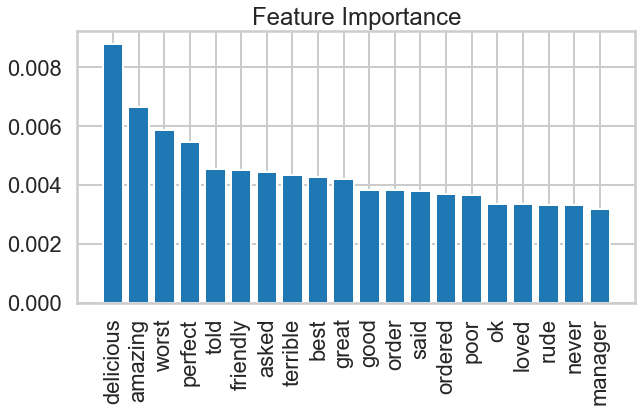

In [45]:
# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
feature_names = list(vectorizer.get_feature_names())
labels = np.array(feature_names)[sorted_index]

# Create Bar Chart
plt.figure(figsize=(10,5))
plt.bar(x[0:20], importances[sorted_index][0:20], tick_label=labels[0:20])

# Rotate tick labels to vertical

plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()

# Coding notes -- reflective thoughts by author

These thoughts are not meant for delivery to customer but could have influence on report writing, personal growth, future analysis, or project continuations. If you want to know how I think it's a fun read I suppose. 



- min_df was interesting since the dataset was so large. Even with min_df=20 there were non-words and other language symbols in the vectorizer. Some analysis of increasing this could be interesting. At 94% of the unique word count removed at min_df=20 I was comfortable leaving it there hoping for low influence on nonsensical/lower frequency tokens.
- The langdetect module used in data cleaning established a language for each review. My assumption for any non-English tokens is that they came from a mixed language review that was predominantly English. I am curious if this or similar packages could be applied to word tokens to assure only the presence of English words.  
- I would love to try tokens of lengths other than word. (Syllables or bi-grams etc.) This may be beyond current scope of project
- Lots of repeating blocks for metrics storage and printing of results. Could be a good use of function but development was far enough along to leave as is. Consider on future projects. 
- Still developing tuning mechanics. Tuning of C in logistic regression model may not have been required, model did not have over-fitting (train/test performance equal). Performance went up 3%. Valid? What are the consequences of tuning when not needed? Is this a successful gain?